# Evasion and Poisoning Attacks on MNIST dataset


In this tutorial we show how to load the **MNIST handwritten digits dataset**
 and use it to train a Support Vector Machine (SVM).

Later we are going to perform Evasion and Poisoning attacks against the trained
 classifier, as previosuly described in [evasion](03-Evasion.ipynb) and
 [poisoning](05-Poisoning.ipynb) tutorials.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/06-MNIST_dataset.ipynb)

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://github.com/pralab/secml

## Training of the classifier

First, we load the dataset and train the classifier. For this tutorial,
 we only consider 2 digits, the 5 (five) and the 9 (nine).

In [2]:
# NBVAL_IGNORE_OUTPUT
from secml.data.loader import CDataLoaderMNIST

# MNIST dataset will be downloaded and cached if needed
loader = CDataLoaderMNIST()

In [3]:
random_state = 999

n_tr = 100  # Number of training set samples
n_val = 500  # Number of validation set samples
n_ts = 500  # Number of test set samples

digits = (5, 9)

tr_val = loader.load('training', digits=digits, num_samples=n_tr + n_val)
ts = loader.load('testing', digits=digits, num_samples=n_ts)

# Split in training and validation set
tr = tr_val[:n_tr, :]
val = tr_val[n_tr:, :]

# Normalize the features in `[0, 1]`
tr.X /= 255
val.X /= 255
ts.X /= 255

from secml.ml.classifiers import CClassifierSVM
# train SVM in the dual space, on a linear kernel, as needed for poisoning
clf = CClassifierSVM(C=10, kernel='linear')

print("Training of classifier...")
clf.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Metric to use for performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Training of classifier...
Accuracy on test set: 93.60%


## Evasion attack with MNIST dataset

Let's define the attack parameters. Firstly, we chose to generate an *l2*
 perturbation within a maximum ball of radius `eps = 2.5` from the initial
 points. Secondly, we also add a low/upper bound as our feature space
 is limited in `[0, 1]`. Lastly, as we are not interested in generating
 adversarial examples for a specific class, we perform an error-generic attack
 by setting `y_target = None`.

*Please note that the attack using the MNIST dataset may take a while
 (up to a few minutes) depending on the machine the script is run on.*

In [4]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:25, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 2.5  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    double_init_ds=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(attack_ds.X, attack_ds.Y)
print("Attack complete!")

acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=clf.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

Attack started...
Attack complete!
Accuracy on reduced test set before attack: 100.00%
Accuracy on reduced test set after attack: 12.00%


We can observe how the classifier trained on the MNIST dataset has been
 *successfully evaded* by the adversarial examples generated by our attack.

Let's now visualize few of the adversarial examples. The first row are the
 original samples and the second row are the adversarial examples. Above each
 digit it is shown the true label and the predicted label in parenthesis.

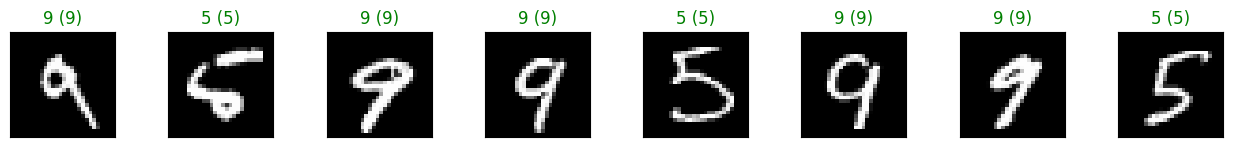

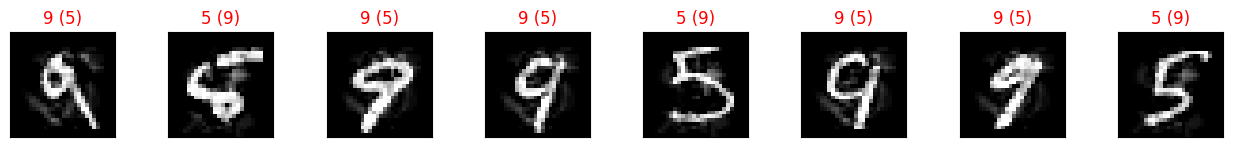

In [5]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=8):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()

show_digits(attack_ds.X, clf.predict(attack_ds.X), attack_ds.Y, digits)
show_digits(eva_adv_ds.X, clf.predict(eva_adv_ds.X), eva_adv_ds.Y, digits)

## Poisoning attack with MNIST dataset

For poisoning attacks the parameters are much simpler. We set the the bounds
 of the attack space and the number of adversarial points to generate,
 50 in this example. Lastly, we chose the solver parameters for this
 specific optimization problem.

*Please note that the attack using the MNIST dataset may take a while
 (up to a few minutes) depending on the machine the script is run on.*


Attack started...
Attack complete!
Original accuracy on test set: 93.60%
Accuracy after attack on test set: 50.40%


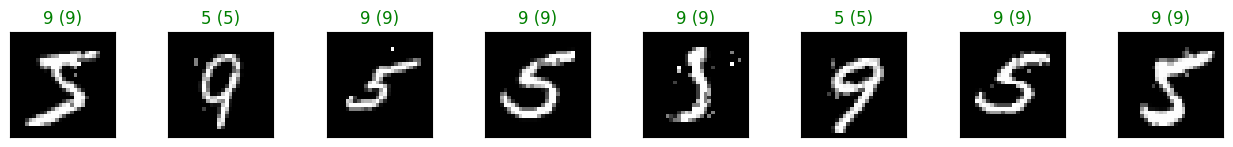

In [6]:
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
n_poisoning_points = 15  # Number of poisoning points to generate

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.25,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, _, pois_points_ds, _ = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=clf.predict(ts.X))
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

# Training of the poisoned classifier for visualization purposes
pois_clf = clf.deepcopy()
pois_tr = tr.append(pois_points_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr.X, pois_tr.Y)

show_digits(pois_points_ds.X, pois_clf.predict(pois_points_ds.X),pois_points_ds.Y, digits)

We can see that the classifier trained on the MNIST dataset has been
 successfully poisoned. To increase the attack power, more poisoning points
 can be crafted, at the expense of a much slower optimization process.

Let's note that the label of each adversarial example we show has been
 *flipped* by the attack with respect to the actual true label. Thus, the
 predicted label (parenthesis) by the poisoned classifier is displayed
 in green when *different* from the true label of the digit.